# Life Expectancy Data Science Project

---------------------------------------------

### Introduction
This analysis explores a life expectancy dataset, aiming to uncover factors affecting life expectancy across countries over time. We'll handle missing values, engineer features, perform exploratory analysis, visualize patterns, and build a regression model to predict life expectancy.

### Objectives
- Understand the structure and quality of the dataset
- Identify key features affecting life expectancy
- Handle missing data appropriately
- Engineer new features to improve prediction
- Visualize relationships and trends
- Build a regression model to predict life expectancy
- Evaluate model performance using cross-validation
- Derive actionable insights

### Task 1: Explore Dataset and Missing Values

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


In [ ]:
df = pd.read_csv('Life_Expectancy_Data.csv')
df.shape 

In [ ]:
df.dtypes

In [ ]:
df.dtypes.value_counts()

In [ ]:
df.columns

In [ ]:
for column in df.columns:
    df.rename(columns={column: column.strip()}, inplace=True)

df.columns

In [ ]:
df.head(20)

In [ ]:
print(df.duplicated())

In [ ]:
#Find total of duplicated values
print(df.duplicated().sum())

In [ ]:
# Get the number of unique countries from the 'Country' column
number_of_countries = df['Country'].nunique()

# Print the number of unique countries
print(f"The total number of unique countries in the dataset is: {number_of_countries}")

### Task 2: Handle Missing Data and Justify Method

In [ ]:
null_values = df.isnull().sum()

In [ ]:
#Checks if any column has NaN
df.isnull().any()

In [ ]:
#Checks if any row has NaN
df.isnull().any(axis=1)

In [ ]:
#Checks if all values in a column are NaN
df.isnull().all()

In [ ]:
#Checks if all values in a row are NaN
df.isnull().all(axis=1)

In [ ]:
null_percentage = (df.isnull().sum() / len(df))*100
print(null_percentage)

In [ ]:
missing_df = pd.DataFrame({'Missing Values': null_values, 'Percent Missing': null_percentage})
missing_df[missing_df['Missing Values'] > 0]

Advanced mechanisms to handle missing data

In [57]:
# Using Z score to detect outliers
from scipy.stats import zscore

# Calculate Z-scores for numerical features
z_scores = zscore(df.select_dtypes(include='number'))
outliers = (abs(z_scores) > 3)

# Count outliers per feature
outliers_df = pd.DataFrame(outliers, columns=df.select_dtypes(include='number').columns)
outliers_df.sum().sort_values(ascending=False)


Polio                              98
Diphtheria                         88
Income composition of resources    48
percentage expenditure             47
HIV/AIDS                           46
GDP                                46
thinness  1-19 years               34
thinness 5-9 years                 34
Measles                            29
Adult Mortality                    28
Health Spending Ratio              26
infant deaths                      24
under-five deaths                  23
Population                         10
Total expenditure                   4
Hepatitis B                         4
Alcohol                             3
Schooling                           2
Deaths per Infant                   2
Life expectancy                     0
Year                                0
BMI                                 0
dtype: int64

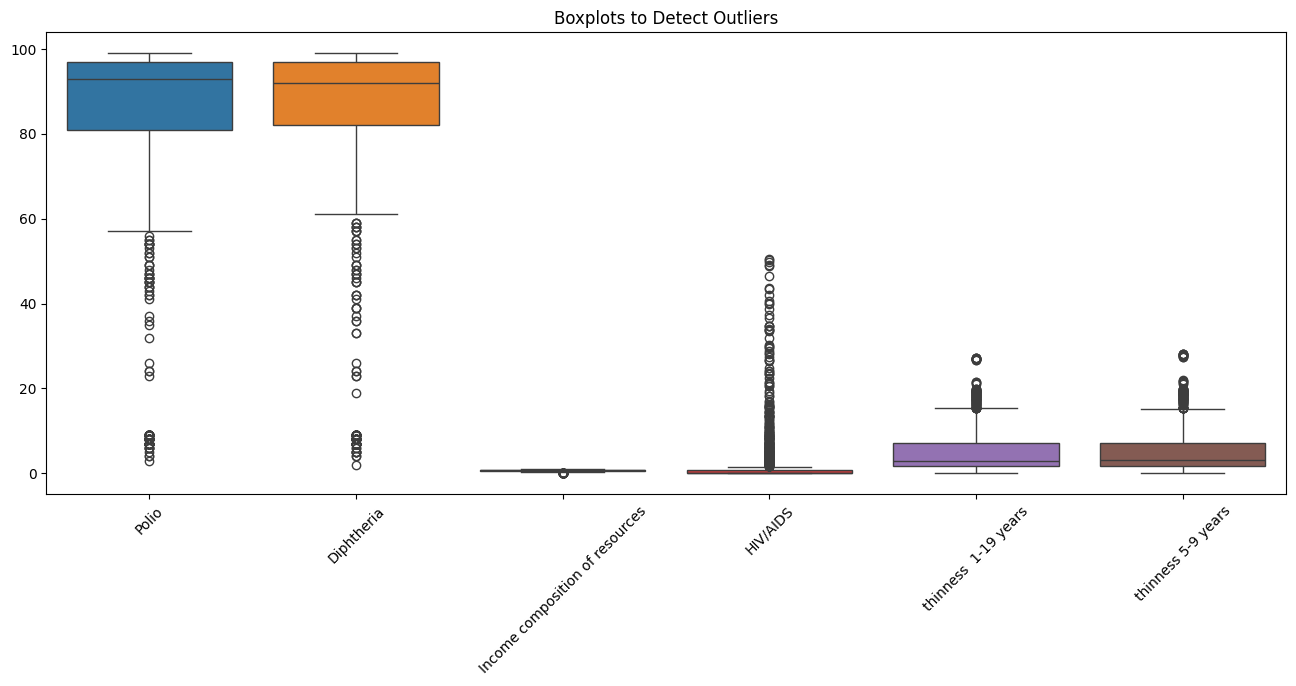

In [58]:
# Visualizing outliers using boxplots
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
sns.boxplot(data=df[['Polio', 'Diphtheria', 'Income composition of resources', 'HIV/AIDS', 'thinness  1-19 years', 'thinness 5-9 years']])
plt.xticks(rotation=45)
plt.title("Boxplots to Detect Outliers")
plt.show()


In [ ]:
# IQR method for outlier detection (Interquartile Range)
outlier_data = []
for col in df.select_dtypes(include='number').columns:
    outliers = detect_outliers_iqr(df[col])
    outlier_data.append({
        'Column': col,
        'Outlier Count': len(outliers),
        'Percentage': round((len(outliers) / len(df)) * 100, 2)
    })

# Create DataFrame and sort by outlier count (descending)
outlier_summary = pd.DataFrame(outlier_data)
outlier_summary = outlier_summary.sort_values('Outlier Count', ascending=False)

# Display as a formatted table
print("Outlier Detection Summary")
print("=" * 40)
print(outlier_summary.to_string(index=False))

Outlier Detection Summary
                         Column  Outlier Count  Percentage
                       HIV/AIDS            299       18.13
                        Measles            297       18.01
              Deaths per Infant            262       15.89
                     Population            233       14.13
              under-five deaths            222       13.46
                            GDP            208       12.61
          Health Spending Ratio            205       12.43
                  infant deaths            199       12.07
         percentage expenditure            187       11.34
                    Hepatitis B            165       10.01
                          Polio            142        8.61
                     Diphtheria            134        8.13
             thinness 5-9 years             78        4.73
           thinness  1-19 years             77        4.67
                Adult Mortality             54        3.27
Income composition of resource

In [ ]:
# Visualizing outliers using boxplots
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
sns.boxplot(data=df[['Measles', 'Population', 'GDP','percentage expenditure', 'Adult Mortality', 'under-five deaths']])
plt.xticks(rotation=45)
plt.title("Boxplots to Detect Outliers")
plt.show()

### Task 3: Apply Chosen Method and Evaluate

In [ ]:
numeric_columns = df.select_dtypes(include = 'number')
df.fillna(df.mean(numeric_only=True), inplace=True)
df.isnull().sum()

In [ ]:
nonNumericColumns = df.select_dtypes(include = 'object')
for column in nonNumericColumns.columns:
    df[column].fillna(df[column].mode()[0])
    
df.isnull().sum()

### Task 4: Identify Potential Features

In [ ]:
# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
#Description of the dataset transposed
df.describe(include='all')

###  Task 5: Feature Engineering

In [ ]:
df['Health Spending Ratio'] = df['Total expenditure'] / df['GDP']
df['Deaths per Infant'] = df['infant deaths'] / df['Population']

### Task 6: Impact of New Features

In [ ]:
df[['Health Spending Ratio', 'Deaths per Infant']].describe()

### Task 7: Select Key Variables for Visualization

In [ ]:
df[['Life expectancy', 'GDP', 'Schooling', 'Alcohol', 'BMI', 'HIV/AIDS']].corr()

### Task 8: Visualizations

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Status', y='Life expectancy', data=df)
plt.title('Life Expectancy by Development Status')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Alcohol', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Alcohol')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Hepatitis B', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Hepatitis B')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='HIV/AIDS', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs HIV/AIDS')
plt.show()

In [ ]:
# 3D Plot
fig = px.scatter_3d(df, x='GDP', y='Schooling', z='Life expectancy',
                     color='Status', size='Population')
fig.show()

### Task 9: Interpretation
- Higher GDP and schooling are associated with higher life expectancy.
- Developing countries tend to have more outliers and lower average life expectancy.
- HIV/AIDS has a strong negative correlation with life expectancy.

### Task 10: Data Splitting and Model Training

In [ ]:
features = ['GDP', 'Schooling', 'Alcohol', 'BMI', 'HIV/AIDS']
X = df[features]
y = df['Life expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

### Task 11: Cross Validation and Model Evaluation

In [ ]:
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
cross_val = cross_val_score(model, X, y, cv=5).mean()
mae, r2, cross_val

### Task 12: Conclusion and Recommendations
- **Key Findings**: Life expectancy is positively influenced by GDP, schooling, and healthcare access. HIV/AIDS is a major negative predictor.
- **Model Performance**: The linear model gives reasonable accuracy with cross-validation.
- **Recommendation**: Focus on improving education, economic stability, and healthcare to raise life expectancy.